<a href="https://colab.research.google.com/github/daothihuyen64/Image_Depth_Estimation/blob/feature%2FImage_Depth_Estimation/Image_Depth_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Get Data

In [ ]:
!gdown 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ

Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 27.9MB/s]


In [ ]:
!unzip tsukuba.zip

Archive:  tsukuba.zip
mapname:  conversion of  failed
 extracting: left.png                
 extracting: right.png               
 extracting: groundtruth.png         


In [ ]:
!gdown 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn

Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 25.6MB/s]


In [ ]:
!unzip Aloe_images.zip

Archive:  Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


# 2. Pixel Wise Matching

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def distance_l1(x, y):
    return abs(x - y)

def pixel_wise_matching_l1(left_img, right_img, disparity_range, save_result=True):
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]
    depth = np.zeros((height, width), dtype=np.uint8)
    scale = 16
    max_value = 255

    for y in range(height):
        for x in range(width):
            cost_min = max_value
            disparity = 0
            for d in range(disparity_range):
                if x - d < 0:
                    cost = max_value
                else:
                    cost = distance_l1(int(left[y, x]), int(right[y, x - d]))

                if cost < cost_min:
                    cost_min = cost
                    disparity = d
            depth[y, x] = disparity * scale

    if save_result:
        print('Saving Result....')
        cv2.imwrite('pixel_wise_l1.png', depth)
        cv2.imwrite('pixel_wise_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))
        print('Done')

    return depth


In [ ]:
def distance_l2(x, y):
    return (x - y) ** 2

def pixel_wise_matching_l2(left_img, right_img, disparity_range, save_result=True):
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]
    depth = np.zeros((height, width), dtype=np.uint8)
    scale = 16
    max_value = 255**2

    for y in range(height):
        for x in range(width):
            cost_min = max_value
            disparity = 0
            for d in range(disparity_range):
                cost = max_value if x - d < 0 else distance_l2(int(left[y, x]), int(right[y, x - d]))

                if cost < cost_min:
                    cost_min = cost
                    disparity = d
            depth[y, x] = disparity * scale

    if save_result:
        print('Saving Result....')
        cv2.imwrite('pixel_wise_l2.png', depth)
        cv2.imwrite('pixel_wise_l2_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))
        print('Done')

    return depth

Saving Result....
Done
Saving Result....
Done


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0, 16,  0],
       [ 0,  0,  0, ..., 16, 32,  0],
       [ 0,  0,  0, ..., 64, 64,  0]], dtype=uint8)
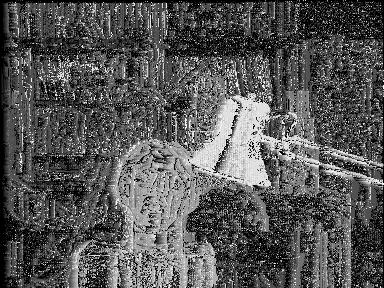

In [ ]:
left_url = '/content/tsukuba/left.png'
right_url = '/content/tsukuba/right.png'
pixel_wise_matching_l1(left_url, right_url,16)
pixel_wise_matching_l2(left_url, right_url,16)

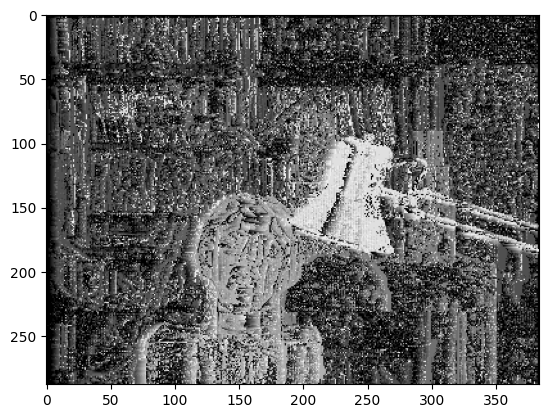

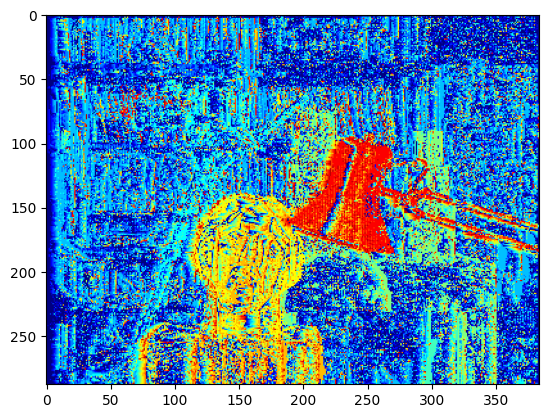

In [38]:
image1 = cv2.imread('pixel_wise_l1.png')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.show()

image2 = cv2.imread('pixel_wise_l1_color.png')
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()


# 3. Window_Based_Matching

In [23]:
def window_based_matching_l1(left_img, right_img, disparity_range, kernel_size = 5):
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]
    depth = np.zeros((height, width), dtype=np.uint8)
    scale = 3
    max_value = 255
    kernel_half = int((kernel_size - 1) / 2)
    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            disparity = 0
            cost_min = 660000
            for d in range(disparity_range):
                total = 0
                cost = 0
                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        if x + u - d < 0:
                            cost = max_value
                        else:
                            cost = distance_l1(int(left[y + v, x + u]), int(right[y + v, x + u - d]))
                        total += cost
                if total < cost_min:
                    cost_min = total
                    disparity = d
            depth[y, x] = disparity * scale
    return depth

In [21]:
def window_based_matching_l2(left_img, right_img, disparity_range, kernel_size = 5):
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]
    depth = np.zeros((height, width), dtype=np.uint8)
    scale = 3
    max_value = 255**2
    kernel_half = (kernel_size - 1) // 2
    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            disparity = 0
            cost_min = 1700000
            for d in range(disparity_range):
                total = 0
                cost = 0
                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        if x + u - d < 0:
                            cost = max_value
                        else:
                            cost = distance_l2(int(left[y + v, x + u]), int(right[y + v, x + u - d]))
                        total += cost
                if total < cost_min:
                    cost_min = total
                    disparity = d
            depth[y, x] = disparity * scale
    return depth




In [24]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_1.png'
disparity_range = 64
kernel_size = 3

In [25]:
depth = window_based_matching_l2(left_img_path, right_img_path, disparity_range, kernel_size)
print('Saving Result....')
cv2.imwrite("window_wise_l2.png", depth)
cv2.imwrite("window_wise_l2_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
print('Done')

Saving Result....
Done


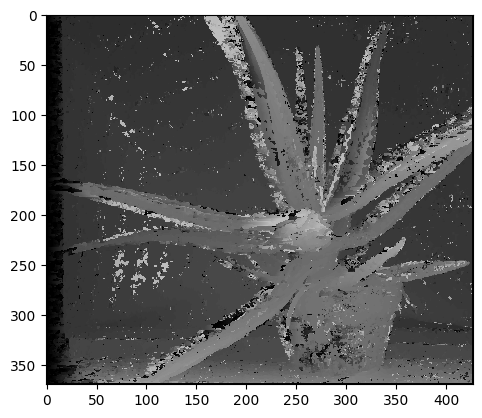

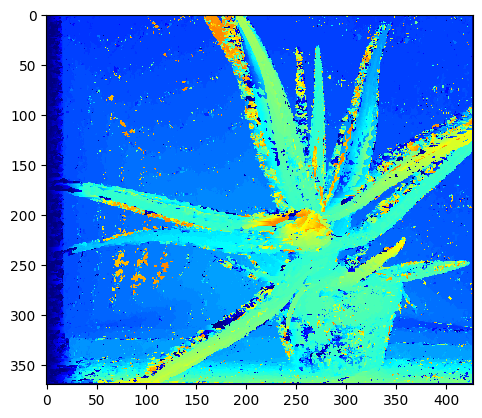

In [39]:
image1 = cv2.imread('window_wise_l2.png')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.show()

image2 = cv2.imread('window_wise_l2_color.png')
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
window_based_matching_l1(left_img_path, right_img_path, disparity_range, kernel_size)
print('Saving Result....')
cv2.imwrite("window_wise_l1.png", depth)
cv2.imwrite("window_wise_l1_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
print('Done')

Saving Result....
Done


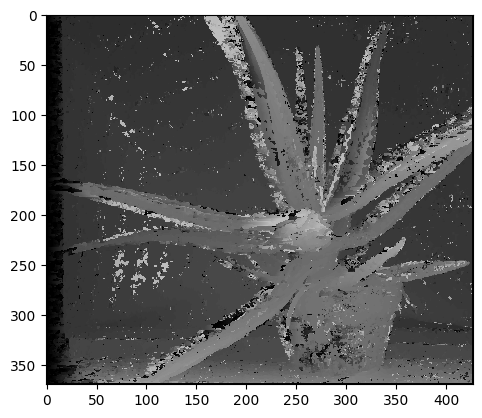

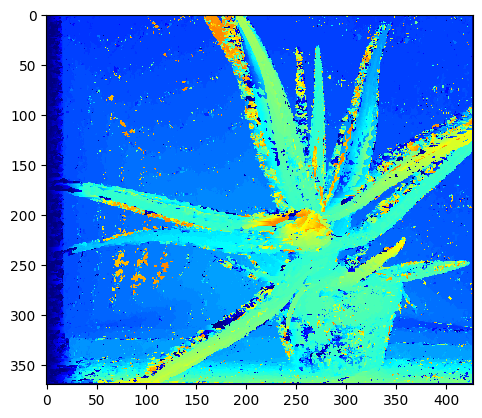

In [40]:
img1 = cv2.imread('window_wise_l1.png')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

img2 = cv2.imread('window_wise_l1_color.png')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

# 4. Problem : Khi 2 ảnh không có cùng độ sáng thì disparity map sẽ bị nhiễu  

In [27]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 3

In [28]:
depth = window_based_matching_l2(left_img_path, right_img_path, disparity_range, kernel_size)
print('Saving Result....')
cv2.imwrite("problem_window_wise_l2.png", depth)
cv2.imwrite("problem_window_wise_l2_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
print('Done')

Saving Result....
Done


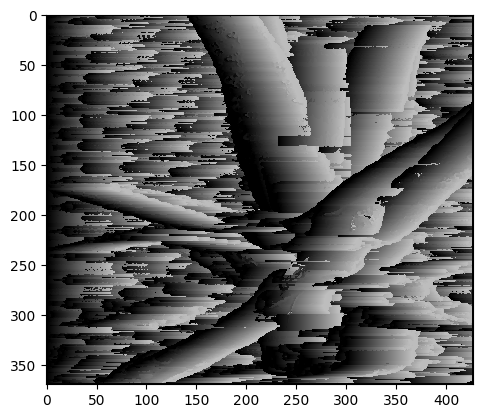

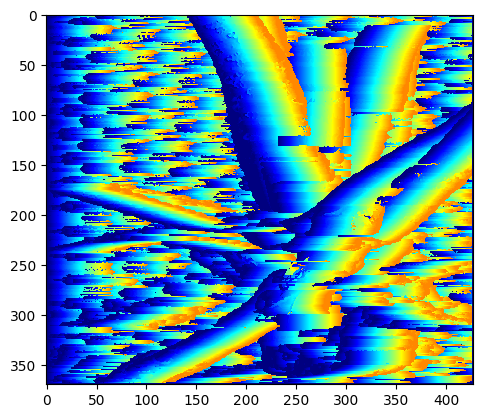

In [41]:
img1 = cv2.imread('problem_window_wise_l2.png')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

img2 = cv2.imread('problem_window_wise_l2_color.png')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

# 5. Sovle Problem

In [30]:
def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [31]:
def window_based_matching ( left_img , right_img , disparity_range , kernel_size =5 ,save_result = True ) :
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)
    height, width = left.shape[:2]
    depth = np.zeros((height, width), dtype=np.uint8)
    scale = 3
    kernel_half = (kernel_size - 1) // 2

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            disparity = 0
            cos_optimal = -1
            for j in range(disparity_range):
                d = x - j
                cost = -1
                if d - kernel_half >= 0:
                  wp = left[ (y-kernel_half) : (y+kernel_half+1) , (x-kernel_half) : (x+kernel_half+1) ]
                  ws = right[ (y-kernel_half) : (y+kernel_half+1) , (d-kernel_half) : (d+kernel_half+1)]
                  cos = cosine_similarity(wp.flatten(), ws.flatten())
                  if cos > cos_optimal:
                    cos_optimal = cos
                    disparity = j

            depth[y, x] = disparity * scale
    if save_result:
        print('Saving Result....')
        cv2.imwrite("window_based_cosine_similarity.png", depth)
        cv2.imwrite("window_based_cosine_similarity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
        print('Done')
    return depth


In [33]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 3
depth = window_based_matching(left_img_path, right_img_path, disparity_range, kernel_size)

Saving Result....
Done


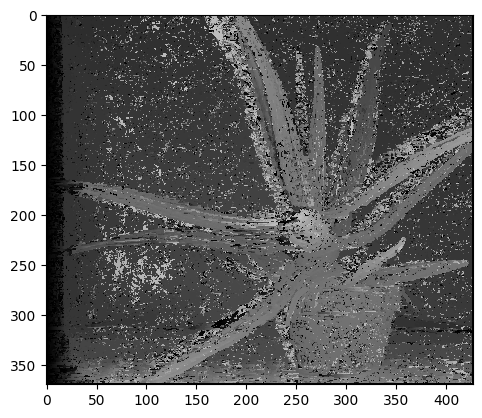

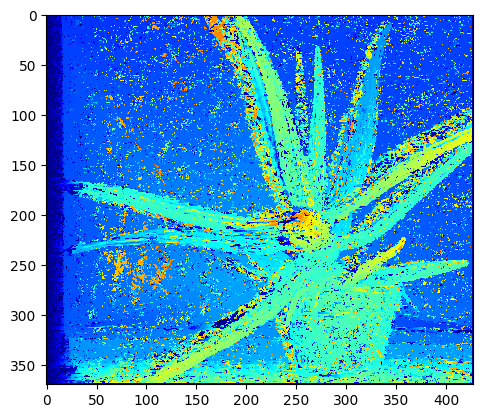

In [42]:
img1 = cv2.imread('window_based_cosine_similarity.png')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

img2 = cv2.imread('window_based_cosine_similarity_color.png')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()